# **PROJET LEYENDA - LIVRABLE 2 : TRAITEMENT D'IMAGE**

   ## **INTRODUCTION**

Dans le cadre du projet TouNum, l'objectif est de créer une solution entièrement automatisée pour analyser et générer des légendes d'images (captioning).
Une étape essentielle pour atteindre cet objectif est d'améliorer la qualité des images afin de les rendre plus adaptées aux tâches ultérieures.

La qualité des images peut avoir un impact significatif sur la précision des modèles de classification et de génération de légendes, en particulier lorsqu'on travaille avec des données bruitées ou de faible qualité.
Par conséquent, une phase de prétraitement efficace des images est indispensable.

Dans ce livrable, le but est de traiter un ensemble d'images bruitées et d'améliorer leur qualité grâce à une technique de débruitage.
La méthode choisie repose sur l'utilisation d'autoencodeurs convolutionnels, un type d'architecture de réseau de neurones spécialement conçue pour le débruitage d'images.
Les autoencodeurs convolutionnels combinent des couches de convolution, qui sont efficaces pour préserver les relations spatiales dans les images, avec la capacité de l'autoencodeur à apprendre des représentations efficaces des données d'entrée.
Cette approche vise à supprimer le bruit tout en conservant les détails importants, ce qui donne des images de meilleure qualité pouvant améliorer la performance des algorithmes en aval.

## **Théorie : les DAE**

Le Denoising Autoencoder est une extension des autoencodeurs classiques, spécifiquement conçue pour améliorer la qualité des données en éliminant le bruit. Contrairement à un autoencodeur traditionnel qui apprend à reproduire ses entrées, le DAE est entraîné avec des images volontairement dégradées, sur lesquelles du bruit est ajouté. L'objectif est que le modèle apprenne à reconstruire l'image d'origine à partir de cette version altérée.

Cette approche présente plusieurs avantages majeurs. En premier lieu, elle empêche le réseau de se contenter de copier mécaniquement l'entrée, ce qui pourrait arriver avec un autoencodeur classique trop complexe. Ensuite, elle permet au modèle de se concentrer sur les caractéristiques importantes de l'image, en apprenant à distinguer les détails pertinents du bruit parasite. Enfin, cette stratégie renforce la robustesse du système face à des données de mauvaise qualité, ce qui est crucial dans le cadre du projet où les images brutes sont souvent bruitées ou de faible résolution.

Grâce au Denoising Autoencoder, les images sont nettoyées avant d'être utilisées par les étapes suivantes du pipeline, comme la classification ou la génération de légendes. Cela contribue à améliorer la précision globale du système de traitement d'images automatique.

![Architecture d'un DAE](DAE.jpeg)




Pour entraîner efficacement le Denoising Autoencoder, il est essentiel d'évaluer la qualité de la reconstruction de l'image propre à partir de sa version bruitée. Cela se fait à l'aide d'une fonction de perte (loss function), qui mesure l'écart entre l'image originale et l'image reconstruite.

Deux fonctions de perte sont couramment utilisées selon le format des données d'entrée :

Mean Squared Error (MSE) : utilisée lorsque les pixels des images sont exprimés par des valeurs continues (par exemple entre 0 et 1 ou 0 à 255). Cette fonction calcule la moyenne des carrés des écarts entre les pixels de l'image originale et ceux de l'image générée.

Binary Cross-Entropy (BCE) : préférable lorsque les images sont binarisées, c'est-à-dire que les pixels prennent uniquement les valeurs 0 ou 1. Cette fonction mesure la différence entre les distributions de pixels de l'entrée et de la sortie.

Le choix de la fonction de perte dépend donc du type de données utilisées, et joue un rôle crucial dans l'optimisation des performances du modèle de débruitage.

## 1. Prétraitement et préparation de l'environnement

In [ ]:
# Import des librairies
import os
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
from collections import defaultdict
import shutil
import random
import cv2
import visualkeras
from zipfile import ZipFile


from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import img_to_array, load_img
from sklearn.model_selection import train_test_split
from PIL import Image

# Affiche les graphiques Matplotlib directement dans le notebook Jupyter.
# %matplotlib inline

In [ ]:
# Extraction du dataset
def extract_dataset(zip_path, extract_to):
    """
    Extrait les fichiers d'un dataset zippé.

    Args:
        zip_path (str): Chemin vers le fichier zip.
        extract_to (str): Dossier où extraire les fichiers.
    """
    # Convertir les chemins en chemins absolus pour éviter les erreurs
    zip_path = os.path.abspath(zip_path)
    extract_to = os.path.abspath(extract_to)

    if not os.path.exists(zip_path):
        raise FileNotFoundError(f"Le fichier {zip_path} n'existe pas.")
    
    # Si le dossier de destination existe, le supprimer
    if os.path.exists(extract_to):
        shutil.rmtree(extract_to)
        print(f"Le dossier existant {extract_to} a été supprimé.")

    os.makedirs(extract_to, exist_ok=True)

    with ZipFile(zip_path, 'r') as zip_ref:
        # Aplatir la structure du zip : extraire les fichiers directement dans extract_to
        for member in zip_ref.namelist():
            filename = os.path.basename(member)
            # Vérifie si c'est un fichier zip contenant 'Livrable 1 - Photo' et 'Livrable 2' dans le nom
            if filename and filename.endswith('.zip') and any(keyword in filename for keyword in ['Livrable 1 - Photo', 'Livrable 2']):
                source = zip_ref.open(member)
                target_path = os.path.join(extract_to, filename)
                with source, open(target_path, "wb") as target:
                    target.write(source.read())
        

    # Extrait le contenu de tous les sous-zip **directement dans extract_to**
    for file in os.listdir(extract_to):
        if file.endswith('.zip'):
            sub_zip_path = os.path.join(extract_to, file)
            with ZipFile(sub_zip_path, 'r') as sub_zip_ref:
                for member in sub_zip_ref.namelist():
                    # Ne garde que le nom du fichier sans les sous-dossiers internes
                    filename = os.path.basename(member)
                    if filename:
                        source = sub_zip_ref.open(member)
                        target_file = os.path.join(extract_to, filename)
                        with source, open(target_file, "wb") as target:
                            target.write(source.read())
            os.remove(sub_zip_path)  # Supprime le zip après extraction
    
    print(f"Dataset extrait dans le dossier : {extract_to}")

def load_images(folder_path):
    """
    Charge toutes les images en mémoire et assure la cohérence des canaux.

    Args:
        folder_path (str): Chemin vers le dataset.
    """
    images = []
    valid_ext = ('.png', '.jpg', '.jpeg')

    # Convertir le chemin en chemins absolus pour éviter les erreurs
    folder_path = os.path.abspath(folder_path)

    # 1. Chargement et vérification des images
    if not os.path.exists(folder_path):
        raise FileNotFoundError(f"Dossier introuvable : {folder_path}")

    for f in os.listdir(folder_path):
        if f.lower().endswith(valid_ext):
            img = Image.open(os.path.join(folder_path, f))
            # Converti en RGB si necessaire pour assurer la coherence
            if img.mode != 'RGB':
                img = img.convert('RGB')
            images.append(np.array(img))

    if not images:
        raise ValueError("Aucune image valide trouvée")

    return images
 
def check_image_resolutions(folder):
    """
    Fonction pour obtenir les résolutions des images d'origine.

    Args:
        folder (str): Chemin vers le dataset.
    """
    # Convertir le chemin en chemin absolu pour éviter les erreurs
    folder = os.path.abspath(folder)

    resolutions = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path)
        if img is not None:
            resolutions.append(img.shape[:2])  # (hauteur, largeur)
    return resolutions


In [ ]:
# Appel de la fonction pour extraire le dataset
dataset_zip_path = './Dataset/Datasets.zip'
# extract_dataset(dataset_zip_path, './Dataset/Dataset2')

In [ ]:
# Configuration
dataset_path = './Dataset/Dataset2/'
img_size = (256, 256)  # Taille de l'image
num_samples = 6 # Nombre d'échantillons à afficher
learning_rate = 0.01  # Taux d'apprentissage
epochs = 25 # nombre epoch alogithme debruiter
batch_size = 32 # taille batch de traitement
# Configurations principales de nos modèles
IMG_SIZE = img_size # taille coté final d'une image en pixel (ici 128x128)

In [ ]:
# Charger les images d'origines
images = load_images(dataset_path)

In [ ]:
# Charge les résolutions des images
resolutions = check_image_resolutions(dataset_path)
heights = [res[0] for res in resolutions]
widths = [res[1] for res in resolutions]

In [ ]:
# 3. Affichage de quelques images avec leurs résolutions d'origine
fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))
for i in range(min(num_samples, len(images))):  # Sélectionner quelques images au hasard pour les afficher
    axes[i].imshow(images[i])
    axes[i].set_title(f" {heights[i]}x{widths[i]}")
    axes[i].axis('off')
plt.tight_layout()
plt.show()

## Redimensionnement du Dataset

Le fait que nos images aient différentes résolutions crée des défis pour l'entraînement d'un modèle de machine learning, notamment pour les réseaux de neurones convolutionnels (CNN), qui nécessitent des images uniformes. Voici pourquoi le redimensionnement est important :

1. **Uniformisation des données** : En redimensionnant toutes les images à une taille commune (par exemple, 128x128 ou 256x256), nous assurons que chaque image a le même nombre de pixels, facilitant ainsi l'apprentissage.

2. **Optimisation des performances** : Les résolutions élevées demandent plus de mémoire et ralentissent l'entraînement. Le redimensionnement permet de réduire la complexité tout en gardant l'essentiel des informations visuelles.

3. **Réduction des biais** : Des images de tailles différentes peuvent introduire un biais, où les plus grandes images sont privilégiées. Le redimensionnement garantit un traitement équitable de toutes les images.

4. **Simplification du prétraitement** : Le redimensionnement facilite également les étapes de prétraitement (comme l'ajout ou le débruitage) en garantissant des tailles uniformes.

Le choix de la taille de redimensionnement dépend du compromis entre la conservation des détails visuels et les exigences en ressources. Par exemple, 128x128 est adapté pour des projets légers, tandis que 256x256 conserve plus de détails mais consomme plus de mémoire et de calcul.

In [ ]:
# 4. Fonction pour Redimensionner les images
def resize_images(images, target_size=img_size):
    """Redimensionne toutes les images et les convertit en RGB"""
    resized_images = []
    for img in images:
        img_pil = Image.fromarray(img).convert('RGB')  # Forcer en RGB
        img_resized = img_pil.resize(target_size)
        resized_images.append(np.array(img_resized))
    return np.array(resized_images)

resized_images = resize_images(images, target_size=img_size)

## Affichage d'échantillon de data correcte

In [ ]:
# 5. Affichage des images redimensionnées
all_images = np.concatenate([resized_images], axis=0)
all_images = np.array(all_images)
print(f"Nombre d'images dans notre dataset : {len(all_images)}")


def display_images(images, num_samples=5):
    """Affiche un échantillon d'images"""
    plt.figure(figsize=(15, 5))
    for i in range(min(num_samples, len(all_images))):
        plt.subplot(1, num_samples, i+1)
        plt.imshow(images[i])
        plt.axis('off')
    plt.tight_layout()  # Ajout pour éviter le chevauchement
    plt.show()

# Appel de la fonction
display_images(all_images)

Dans cette partie, nous chargeons les images du dataset, vérifions leurs résolutions et les redimensionnons à une taille uniforme (256x256 pixels). Cela garantit que toutes les images ont les mêmes dimensions, ce qui est essentiel pour l’entraînement du modèle d'autoencodeur.

Nous pouvons également constaté que nous n'avons que 148 images dans notre Dataset ce qui est très peu pour notre modèle. C'est un risque de surapprentissage (overfitting). Avec un petit dataset, il est facile pour un modèle de surapprendre les données, c'est-à-dire de mémoriser les images spécifiques au lieu d'apprendre des motifs généraux.

Un petit dataset limite la quantité d'informations que le modèle peut exploiter, ce qui pourrait limiter ses performances finales, surtout sur des architectures complexes comme les autoencodeurs convolutionnels, qui ont beaucoup de paramètres à entraîner.

## Analyse des pixels et des couleurs des images

In [ ]:
#Analyse des pixels : calcul des statistiques

def calculate_image_statistics(all_images):
    """Calcule des statistiques sur les images"""
    pixel_values  = np.concatenate([img.ravel() for img in images]) #Rassemble tous les pixels de toutes les images en un seul tableau unidimensionnel
    mean = np.mean(pixel_values)
    std = np.std(pixel_values)
    median = np.median(pixel_values)

    return mean, std, median, pixel_values

# mean, std, median, pixel_values = calculate_image_statistics(all_images)

#Affichage des statistiques
# print(f"Moyenne : {mean}")
# print(f"Écart type : {std}")
# print(f"Médiane : {median}")

#Fonction pour visualiser la distribution des couleurs
def plot_color_distribution(all_images):
    """Affiche la distribution des couleurs des images"""
    reds = np.concatenate([img[:, :, 2].ravel() for img in images])
    greens = np.concatenate([img[:, :, 1].ravel() for img in images])
    blues = np.concatenate([img[:, :, 0].ravel() for img in images])

    plt.figure(figsize=(10, 5))
    plt.hist(reds, bins=50, color='red', alpha=0.5, label='Rouge') #extrait la composante rouge de chaque image, aplatit ces valeurs en un vecteur puis concatène tous ces vecteurs en un seul grand vecteur reds
    plt.hist(greens, bins=50, color='green', alpha=0.5, label='Vert')
    plt.hist(blues, bins=50, color='blue', alpha=0.5, label='Bleu')
    plt.title("Distribution des couleurs des images")
    plt.xlabel("Valeur des pixel (0-255)")
    plt.ylabel("Nombre de pixels")
    plt.legend()
    plt.show()

Dans notre jeu d'images, après avoir analysé les valeurs des pixels, voici les résultats obtenus :

Moyenne des pixels : 117.68

Écart-type des pixels : 71.70

Médiane des pixels : 115.00


Interprétation des résultats :
Moyenne des pixels : La moyenne est proche du centre de la plage [0, 255], indiquant que nos images ont une luminosité moyenne légèrement plus sombre que le milieu de l'échelle. Elles contiennent un bon équilibre entre zones sombres et claires, mais avec une légère prédominance de zones sombres.

Médiane des pixels : La médiane est très proche de la moyenne, ce qui montre que la distribution des pixels est relativement symétrique, sans valeurs extrêmes.

Écart-type : L'écart-type élevé (71.70) indique une grande variabilité des pixels, avec un bon contraste entre les zones très sombres et très claires, ce qui est utile pour les algorithmes de traitement d'image.


Nos images ont une luminosité légèrement inférieure à la moyenne, une distribution symétrique des valeurs de pixels et un bon contraste. Cela est idéal pour les phases de traitement d'image, car cela permet au modèle de mieux détecter les détails et les transitions dans les images.

In [ ]:
# plot_color_distribution(all_images)

Contraste dans les Images :
Les pics aux extrêmes (0 et 1) dans la distribution des pixels indiquent un fort contraste dans les images, ce qui est important pour la netteté des bords et les zones de transition rapide. Lors du traitement, il est crucial de préserver ces zones pour ne pas altérer les détails fins et maintenir la clarté de l'image.

Variabilité des Couleurs :
Les différentes distributions entre les canaux (rouge, vert, bleu) montrent une bonne diversité des couleurs, bien que les teintes bleutées prédominent légèrement. Cela peut influencer la manière dont l'autoencodeur doit traiter chaque canal pour améliorer la qualité globale tout en respectant cette variation de couleurs.

Ajout de Bruit et Dégradation :
Lors de l'ajout de bruit, il est essentiel d'observer comment le bruit affecte les pics aux extrêmes et les zones intermédiaires. Lors du débruitage, l'autoencodeur doit être capable de reconstruire correctement ces zones de fort contraste et les couleurs dominantes.

In [ ]:
# Nouvelle fonction de data augmentation
# def augment_images(images, augment_factor=2): # Augmente le nombre d'images
#     """Génère des images augmentées"""
#     datagen = ImageDataGenerator(
#         rotation_range=20,
#         width_shift_range=0.1,
#         height_shift_range=0.1,
#         shear_range=0.2,
#         zoom_range=0.2,
#         horizontal_flip=True,
#         fill_mode='reflect' #Les bords sont remplis par effet miroir : les valeurs de pixels sont copiées en sens inversé
#    )

#     augmented_images = []
#     for img in images:
#         img = img.reshape((1,) + img.shape)
#         for _ in range(augment_factor):
#             for batch in datagen.flow(img, batch_size=1):
#                 augmented_images.append(batch[0])
#                 break
#     return np.array(augmented_images)

# Application avant le split
# print("Augmentation des données...")
# augmented_images = augment_images(all_images)
# all_images = np.concatenate([all_images, augmented_images])
# print(f"Nouveau nombre total d'images: {len(all_images)}")

In [ ]:
def preprocess_data(images):
    """Normalisation et redimensionnement"""
    images = images.astype('float32') / 255.  # Normalisation
    return images

# Split train/test
x_train, x_test = train_test_split(all_images, test_size=0.2, random_state=42)

# Application du prétraitement
x_train = preprocess_data(x_train)
x_test = preprocess_data(x_test)

print(f"\nForme des données :")
print(f"Train: {x_train.shape} (ex: {x_train[0].shape})")
print(f"Nombre d'images d'entrainement : {len(x_train) }")
print(f"Test: {x_test.shape} (ex: {x_test[0].shape})")
print(f"Nombre d'images test : {len(x_test) }")

In [ ]:
display_images(x_train, num_samples=6)

# Auto-encodeur de réduction de bruit (denoiser)
## Ajout du bruit au images :

In [ ]:

def add_noise(images, noise_type="gaussian", noise_factor=0.2):
    noisy_images = images.copy()

    if noise_type == "gaussian":
        noise = noise_factor * np.random.normal(loc=0.0, scale=1.0, size=images.shape)
        noisy_images += noise

    elif noise_type == "poisson":
        noise = np.random.poisson(images * 255.0) / 255.0  # Convert to 0-1 range
        noisy_images += (1-noise_factor) * images + noise_factor * noise

    elif noise_type == "speckle":
        noise = noise_factor * np.random.randn(*images.shape)
        noisy_images += images * noise

    elif noise_type == "salt_pepper":
        prob = noise_factor / 2
        rnd = np.random.rand(*images.shape)
        noisy_images[rnd < prob] = 0  # Sel (noir)
        noisy_images[rnd > (1 - prob)] = 1  # Poivre (blanc)

    return np.clip(noisy_images, 0., 1.)

In [ ]:
# Appliquer plusieurs types de bruits
x_train_noisy_gaussian = add_noise(x_train, "gaussian")
x_test_noisy_gaussian = add_noise(x_test, "gaussian")

# x_train_noisy_poisson = add_noise(x_train, "poisson")
# x_test_noisy_poisson = add_noise(x_test, "poisson")

# x_train_noisy_speckle = add_noise(x_train, "speckle")
# x_test_noisy_speckle = add_noise(x_test, "speckle")

x_train_noisy_sp = add_noise(x_train, "salt_pepper")
x_test_noisy_sp = add_noise(x_test, "salt_pepper")

In [ ]:
print("Images d'origine :")
display_images(x_train, num_samples=5)
print("Images bruitées (gaussien) :")
display_images(x_train_noisy_gaussian, num_samples=5)
# print("Images bruitées (poisson) :")
# display_images(x_train_noisy_poisson, num_samples=5)
# print("Images bruitées (speckle) :")
# display_images(x_train_noisy_speckle, num_samples=5)
# print("Images bruitées (sel et poivre) :")
# display_images(x_train_noisy_sp, num_samples=5)

In [ ]:
print("Dimensions des données :")
print("x_test shape:", x_test.shape)          # Doit être (N, 256, 256, 3)


## Encodeur

In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout, Input, Flatten, Dense, Reshape
# Data augmentation
# data_augmentation = keras.Sequential(
#     [
#         layers.RandomFlip('horizontal'),
#         layers.RandomRotation(0.1),
#         layers.RandomZoom(0.1)
#     ],
#     name="data_augmentation"
# )
# Applique la data augmentation directement à l'entrée
# x = data_augmentation(input_img)

# Entrée de l'image
input_img = Input(shape=(img_size[0], img_size[1], 3))  # à adapter selon ta taille d’image

# Bloc 1
x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)

# Bloc 2
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)


## Decodeur

In [ ]:
from tensorflow.keras.layers import UpSampling2D, Dropout

# Bloc 1
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)

# Bloc 2
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)

# Dernière couche (sortie)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Création des modèles basqiques pour chaque bruit
autoencoder_gaussian = Model(input_img, decoded)
# autoencoder_poisson = Model(input_img, decoded)
# autoencoder_speckle = Model(input_img, decoded)
autoencoder_sp = Model(input_img, decoded)

# Compilation des modèles basique pour chaque bruit
autoencoder_gaussian.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse',  metrics=['accuracy'])  # MSE au lieu de binary_crossentropy pour les images continues
# autoencoder_poisson.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse',  metrics=['accuracy'])  # MSE au lieu de binary_crossentropy pour les images continues
# autoencoder_speckle.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse',  metrics=['accuracy'])  # MSE au lieu de binary_crossentropy pour les images continues
autoencoder_sp.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse',  metrics=['accuracy'])  # MSE au lieu de binary_crossentropy pour les images continues

# Compilation des modèles avec custom loss pour chaque bruit
def custom_kl_loss(y_true, y_pred):
    # Ajout d'un epsilon pour éviter les log(0)
    epsilon = 1e-7
    y_true = tf.clip_by_value(y_true, epsilon, 1.0)
    y_pred = tf.clip_by_value(y_pred, epsilon, 1.0)

    # KL divergence : KL(y_true || y_pred)
    kl = y_true * tf.math.log(y_true / y_pred)
    return tf.reduce_mean(tf.reduce_sum(kl, axis=[1, 2, 3]))  # Moyenne sur les batchs

# # Création des modèles avec custom loss pour chaque bruit
# autoencoder_gaussian_kl = Model(input_img, decoded)
# autoencoder_poisson_kl = Model(input_img, decoded)
# autoencoder_speckle_kl = Model(input_img, decoded)
autoencoder_sp_kl = Model(input_img, decoded)

# # Compilation des modèles avec custom loss pour chaque bruit
# autoencoder_gaussian_kl.compile(optimizer=Adam(learning_rate=learning_rate), loss=custom_kl_loss, metrics=['accuracy'])
# autoencoder_poisson_kl.compile(optimizer=Adam(learning_rate=learning_rate), loss=custom_kl_loss, metrics=['accuracy'])
# autoencoder_speckle_kl.compile(optimizer=Adam(learning_rate=learning_rate), loss=custom_kl_loss, metrics=['accuracy'])
autoencoder_sp_kl.compile(optimizer=Adam(learning_rate=learning_rate), loss=custom_kl_loss, metrics=['accuracy'])


# Affichage du résumé d'un des modèles
autoencoder_gaussian.summary()


## Entrainement

In [ ]:
from tensorflow.keras.utils import plot_model
# plot_model(autoencoder_gaussian, to_file='autoencoder_architecture.png', show_shapes=True, show_layer_names=True)

import visualkeras
visualkeras.layered_view(autoencoder_gaussian, to_file='./autoencoder.png',
    legend=True,                                 
    scale_xy=1.5,               
    scale_z=0.6,               
    spacing=40,                
    draw_volume=True)

In [ ]:
# Entraînement des modèles classiques
AUTOTUNE = tf.data.experimental.AUTOTUNE


# x_test_noisy_gaussian = x_test_noisy_gaussian.cache().prefetch(buffer_size=AUTOTUNE)
# history_gaussian = autoencoder_gaussian.fit(
#     x_train_noisy_gaussian, x_train,
#     epochs=epochs,
#     batch_size=batch_size,
#     shuffle=True,
#     validation_data=(x_test_noisy_gaussian, x_test)
# )

# # x_test_noisy_poisson = x_test_noisy_poisson.cache().prefetch(buffer_size=AUTOTUNE)
# history_poisson = autoencoder_poisson.fit(
#     x_train_noisy_poisson, x_train,
#     epochs=epochs,
#     batch_size=batch_size,
#     shuffle=True,
#     validation_data=(x_test_noisy_poisson, x_test)
# )

# # x_test_noisy_speckle = x_test_noisy_speckle.cache().prefetch(buffer_size=AUTOTUNE)
# history_speckle = autoencoder_speckle.fit(
#     x_train_noisy_speckle, x_train,
#     epochs=epochs,
#     batch_size=batch_size,
#     shuffle=True,
#     validation_data=(x_test_noisy_speckle, x_test)
# )

# x_test_noisy_sp = x_test_noisy_sp.cache().prefetch(buffer_size=AUTOTUNE)
history_sp = autoencoder_sp.fit(
    x_train_noisy_sp, x_train,
    epochs=epochs,
    batch_size=batch_size,
    shuffle=True,
    validation_data=(x_test_noisy_sp, x_test)
)
# # Entraînement des modèles avec custom loss
# history_gaussian_kl = autoencoder_gaussian_kl.fit(
#     x_train_noisy_gaussian, x_train,
#     epochs=epochs,
#     batch_size=batch_size,
#     shuffle=True,
#     validation_data=(x_test_noisy_gaussian, x_test)
# )
# history_poisson_kl = autoencoder_poisson_kl.fit(
#     x_train_noisy_poisson, x_train,
#     epochs=epochs,
#     batch_size=batch_size,
#     shuffle=True,
#     validation_data=(x_test_noisy_poisson, x_test)
# )
# history_speckle_kl = autoencoder_speckle_kl.fit(
#     x_train_noisy_speckle, x_train,
#     epochs=epochs,
#     batch_size=batch_size,
#     shuffle=True,
#     validation_data=(x_test_noisy_speckle, x_test)
# )
# history_sp_kl = autoencoder_sp_kl.fit(
#     x_train_noisy_sp, x_train,
#     epochs=epochs,
#     batch_size=batch_size,
#     shuffle=True,
#     validation_data=(x_test_noisy_sp, x_test)
# )

In [ ]:
# Sauvegarde des modèles classique
# autoencoder_gaussian.save("autoencoder_gaussian2.h5")
# autoencoder_gaussian.save("autoencoder_gaussian2.keras")

# autoencoder_poisson.save("autoencoder_poisson2.h5")
# autoencoder_poisson.save("autoencoder_poisson2.keras")

# autoencoder_speckle.save("autoencoder_speckle2.h5")
# autoencoder_speckle.save("autoencoder_speckle2.keras")

autoencoder_sp.save("autoencoder_sp2.h5")
autoencoder_sp.save("autoencoder_sp2.keras")

# # Sauvegarde des modèles avec custom loss
# autoencoder_gaussian_kl.save("autoencoder_gaussian2.h5")
# autoencoder_gaussian_kl.save("autoencoder_gaussian2.keras")

# autoencoder_poisson_kl.save("autoencoder_poisson2.h5")
# autoencoder_poisson_kl.save("autoencoder_poisson2.Keras")

# autoencoder_speckle_kl.save("autoencoder_speckle2.h5")
# autoencoder_speckle_kl.save("autoencoder_speckle2.keras")

# autoencoder_sp_kl.save("autoencoder_sp2.h5")
# autoencoder_sp_kl.save("autoencoder_sp2.keras")

In [ ]:
# Visualisation des pertes d'apprentissage (Train) et de validation (Test) des modèles classiques

plt.figure(figsize=(10, 5))

fig, axes = plt.subplots(1, 4, figsize=(20, 5))

# Gaussian Noise
# axes[0].plot(history_gaussian.history['loss'], label='Train')
# axes[0].plot(history_gaussian.history['val_loss'], label='Test')
# axes[0].set_title("Gaussian Noise")
# axes[0].set_xlabel('Epochs')
# axes[0].set_ylabel('Loss')
# axes[0].legend()

# Poisson Noise
# axes[1].plot(history_poisson.history['loss'], label='Train')
# axes[1].plot(history_poisson.history['val_loss'], label='Test')
# axes[1].set_title("Poisson Noise")
# axes[1].set_xlabel('Epochs')
# axes[1].set_ylabel('Loss')
# axes[1].legend()

# # Speckle Noise
# axes[2].plot(history_speckle.history['loss'], label='Train')
# axes[2].plot(history_speckle.history['val_loss'], label='Test')
# axes[2].set_title("Speckle Noise")
# axes[2].set_xlabel('Epochs')
# axes[2].legend()

# Salt & Pepper Noise
axes[2].plot(history_sp.history['accuracy'], label='Train')
axes[2].plot(history_sp.history['val_accuracy'], label='Test')
axes[2].set_title("Salt & Pepper Noise")
axes[2].set_xlabel('Epochs')
axes[2].legend()

axes[3].plot(history_sp.history['loss'], label='Train')
axes[3].plot(history_sp.history['val_loss'], label='Test')
axes[3].set_title("Salt & Pepper Noise")
axes[3].set_xlabel('Epochs')
axes[3].legend()

plt.tight_layout()
plt.show()


In [ ]:
# Visualisation des pertes d'apprentissage (Train) et de validation (Test) des modèles avec une custom loss
plt.figure(figsize=(10, 5))

fig, axes = plt.subplots(1, 4, figsize=(15, 5))

# Gaussian Noise
# axes[0].plot(history_gaussian_kl.history['loss'], label='Train')
# axes[0].plot(history_gaussian_kl.history['val_loss'], label='Test')
# axes[0].set_title("Gaussian Noise kl")
# axes[0].set_xlabel('Epochs')
# axes[0].set_ylabel('Loss')
# axes[0].legend()

# # Poisson Noise
# axes[1].plot(history_poisson_kl.history['loss'], label='Train')
# axes[1].plot(history_poisson_kl.history['val_loss'], label='Test')
# axes[1].set_title("Poisson Noise kl")
# axes[1].set_xlabel('Epochs')
# axes[1].set_ylabel('Loss')
# axes[1].legend()

# # Speckle Noise
# axes[2].plot(history_speckle_kl.history['loss'], label='Train')
# axes[2].plot(history_speckle_kl.history['val_loss'], label='Test')
# axes[2].set_title("Speckle Noise kl")
# axes[2].set_xlabel('Epochs')
# axes[2].legend()

# Salt & Pepper Noise
# axes[3].plot(history_sp_kl.history['loss'], label='Train')
# axes[3].plot(history_sp_kl.history['val_loss'], label='Test')
# axes[3].set_title("Salt & Pepper Noise")
# axes[3].set_xlabel('Epochs')
# axes[3].legend()

plt.tight_layout()
plt.show()


In [ ]:
print("Dimensions des données :")
print("x_test shape:", x_test.shape)          # Doit être (N, 256, 256, 3)

print("Modèle input shape:", autoencoder_gaussian.input_shape)  # Doit être (None, 256, 256, 3)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import uniform_filter

def psnr(original, compressed):
    mse = np.mean((original - compressed) ** 2)
    if mse == 0:
        return float('inf')
    max_pixel = 1.0
    return 20 * np.log10(max_pixel / np.sqrt(mse))

def ssim_v1(original, compressed, window_size=11):
    original = original.astype(np.float32)
    compressed = compressed.astype(np.float32)

    if original.shape != compressed.shape:
        print(f"Shape mismatch: {original.shape} vs {compressed.shape}")
        return np.nan

    C1 = (0.01 * 1) ** 2  # 1.0 si image normalisée
    C2 = (0.03 * 1) ** 2

    # Moyennes locales
    mu1 = uniform_filter(original, window_size)
    mu2 = uniform_filter(compressed, window_size)

    mu1_sq = mu1 ** 2
    mu2_sq = mu2 ** 2
    mu1_mu2 = mu1 * mu2

    # Variances locales
    sigma1_sq = uniform_filter(original ** 2, window_size) - mu1_sq
    sigma2_sq = uniform_filter(compressed ** 2, window_size) - mu2_sq
    sigma12 = uniform_filter(original * compressed, window_size) - mu1_mu2

    # SSIM map
    ssim_map = ((2 * mu1_mu2 + C1) * (2 * sigma12 + C2)) / \
               ((mu1_sq + mu2_sq + C1) * (sigma1_sq + sigma2_sq + C2))

    return np.mean(ssim_map)

def visualize_denoising(model, clean_images, noisy_images, num_samples=3):
    num_samples = min(num_samples, len(clean_images))
    print(f"\nVisualisation de {num_samples} échantillons...")

    try:
        denoised = model.predict(noisy_images[:num_samples], verbose=0)
        print("Prédiction réussie.")
    except Exception as e:
        print("\nÉchec de prédiction :")
        print(f"Erreur : {e}")
        return

    plt.figure(figsize=(15, 8), dpi=100)

    for i in range(num_samples):
        # print("clean:", clean_images[i].shape)
        # print("noisy:", noisy_images[i].shape)
        # print("denoised:", denoised[i].shape)
        # Valeurs par défaut
        psnr_n = psnr_d = float('nan')
        ssim_value_n = ssim_value_d = float('nan')

        try:
            psnr_n = psnr(clean_images[i], noisy_images[i])
            psnr_d = psnr(clean_images[i], denoised[i])
            ssim_value_n = ssim_v1(clean_images[i], noisy_images[i])
            ssim_value_d = ssim_v1(clean_images[i], denoised[i])
        except Exception as e:
            print(f"Erreur lors du calcul des métriques pour l'image {i} : {e}")

        cmap_mode = 'gray' if clean_images[i].shape[-1] == 1 else None

        # Image originale
        plt.subplot(3, num_samples, i + 1)
        plt.imshow(clean_images[i].squeeze(), cmap=cmap_mode)
        plt.title("Original", fontsize=8)
        plt.axis('off')

        # Image bruitée
        plt.subplot(3, num_samples, i + 1 + num_samples)
        plt.imshow(noisy_images[i].squeeze(), cmap=cmap_mode)
        plt.title(f"Noisy\nPSNR: {psnr_n:.2f} dB", fontsize=8)
        plt.text(0, 15, f"SSIM value: {ssim_value_n:.2f}", color='white', fontsize=8, backgroundcolor='black')
        plt.axis('off')

        # Image débruitée
        plt.subplot(3, num_samples, i + 1 + 2 * num_samples)
        # plt.imshow(denoised[i].squeeze(), cmap=cmap_mode)
        img = denoised[i].squeeze()
        img = (img - img.min()) / (img.max() - img.min() + 1e-8)
        plt.imshow(img, cmap=cmap_mode)
        plt.title(f"Denoised\nPSNR: {psnr_d:.2f} dB", fontsize=8)
        plt.text(0, 15, f"SSIM value: {ssim_value_d:.2f}", color='white', fontsize=8, backgroundcolor='black')
        plt.axis('off')

    plt.tight_layout()
    plt.show()
    print("Visualisation terminée !")

=== Test de visualisation ===
x_test_noisy shape: (2029, 256, 256, 3)
== Gaussian ==
== Sp ==

Visualisation de 3 échantillons...
Prédiction réussie.


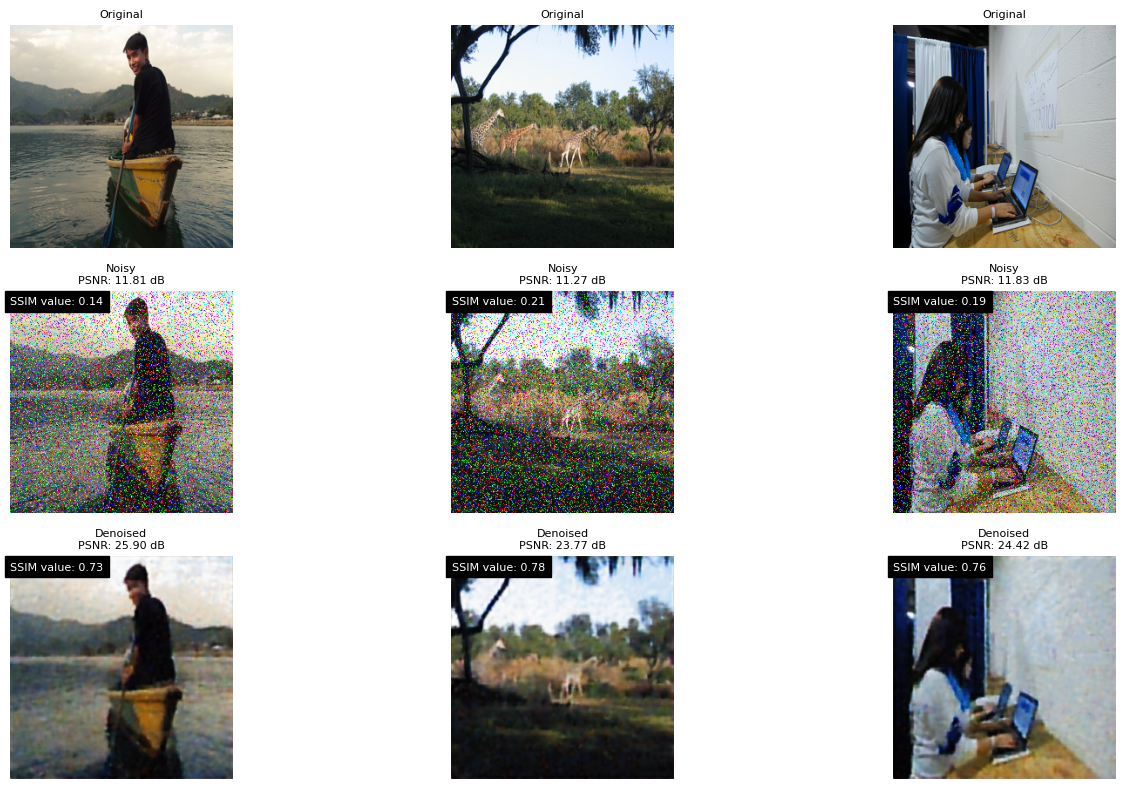

Visualisation terminée !
== Sp kl ==

Visualisation de 3 échantillons...
Prédiction réussie.


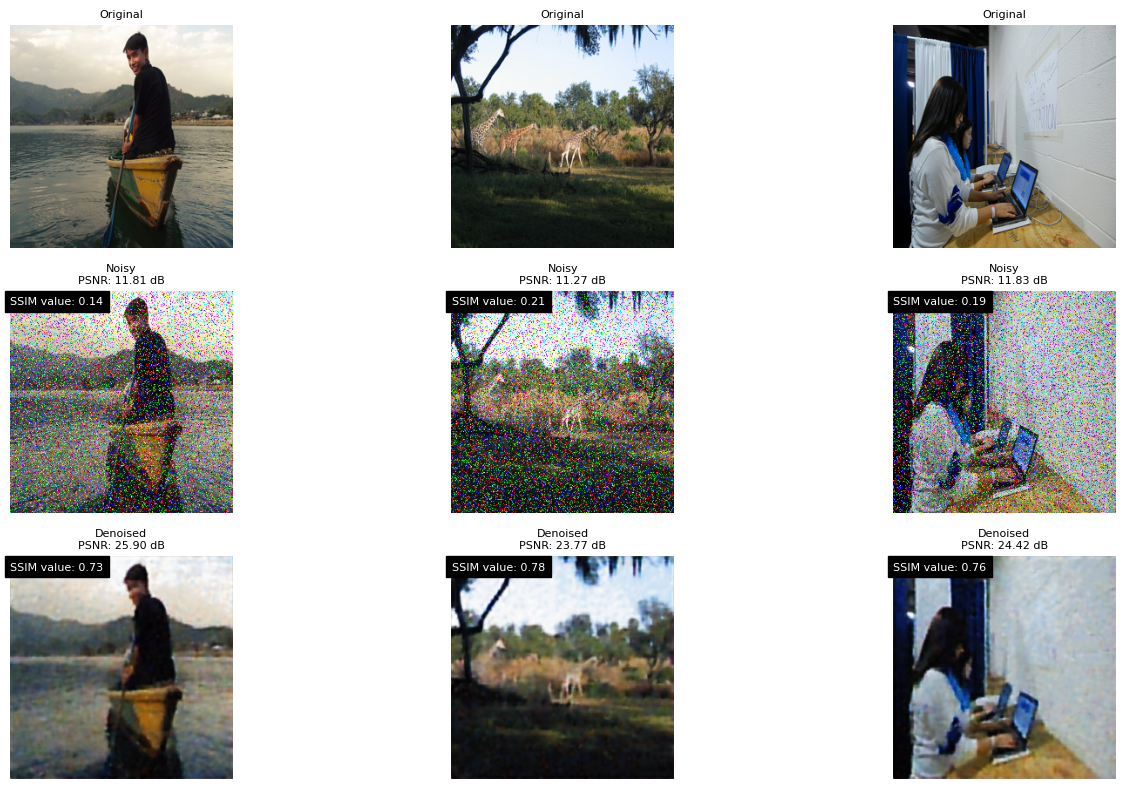

Visualisation terminée !


In [37]:
# Test final
print("=== Test de visualisation ===")
print("x_test_noisy shape:", x_test_noisy_gaussian.shape)  # Doit être (N, 256, 256, 3)
print("== Gaussian ==")
# visualize_denoising(autoencoder_gaussian, x_test[:3], x_test_noisy_gaussian[:3])  # Test avec 3 échantillons
# print("== Poisson ==")
# visualize_denoising(autoencoder_poisson, x_test[:3], x_test_noisy_poisson[:3])  # Test avec 3 échantillons
# print("== Speckle ==")
# visualize_denoising(autoencoder_speckle, x_test[:3], x_test_noisy_speckle[:3])  # Test avec 3 échantillons
print("== Sp ==")
visualize_denoising(autoencoder_sp, x_test[:3], x_test_noisy_sp[:3])  # Test avec 3 échantillons

print("== Sp kl ==")
visualize_denoising(autoencoder_sp_kl, x_test[:3], x_test_noisy_sp[:3])  # Test avec 3 échantillons